In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import Embedding, Input, Dot, Add, Flatten, Dense, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split

2023-06-16 12:28:46.943726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 12:28:47.009873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 12:28:47.011175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 12:28:48.057538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('filtered_ratings.csv')
N = df['userId'].nunique()
M = df['movieId'].nunique()
N, M

(85078, 8473)

In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
if train['userId'].nunique()!=N or train['movieId'].nunique()!=M:
    print("change random state")

In [4]:
K = 10
reg = 0.1
mu = train['rating'].mean()

In [5]:
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m)
x = Concatenate(axis=2)([u_embedding, u_bias, m_embedding, m_bias])
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(1)(x)

In [6]:
model = Model(inputs=[u,m], outputs=[x])
model.compile(loss='mse', optimizer=SGD(learning_rate=0.02))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        850780      ['input_1[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 1)         85078       ['input_1[0][0]']                
                                                                                              

In [7]:
r = model.fit(x = [train.userId.values, train.movieId.values], y = train.rating.values-mu, batch_size=1024, epochs=10, 
              validation_data=([test.userId.values, test.movieId.values], test.rating.values-mu))

Epoch 1/10
14088/14088 [==============================] - 101s 7ms/step - loss: 1.8328 - val_loss: 0.9959
Epoch 2/10
14088/14088 [==============================] - 98s 7ms/step - loss: 0.9626 - val_loss: 0.9648
Epoch 3/10
14088/14088 [==============================] - 97s 7ms/step - loss: 0.9528 - val_loss: 0.9524
Epoch 4/10
14088/14088 [==============================] - 98s 7ms/step - loss: 0.9501 - val_loss: 0.9426
Epoch 5/10
14088/14088 [==============================] - 97s 7ms/step - loss: 0.9521 - val_loss: 0.9447
Epoch 6/10
14088/14088 [==============================] - 97s 7ms/step - loss: 0.9526 - val_loss: 0.9441
Epoch 7/10
14088/14088 [==============================] - 97s 7ms/step - loss: 0.9503 - val_loss: 0.9483
Epoch 8/10
14088/14088 [==============================] - 98s 7ms/step - loss: 0.9500 - val_loss: 0.9501
Epoch 9/10
14088/14088 [==============================] - 94s 7ms/step - loss: 0.9503 - val_loss: 0.9728
Epoch 10/10
14088/14088 [=============================

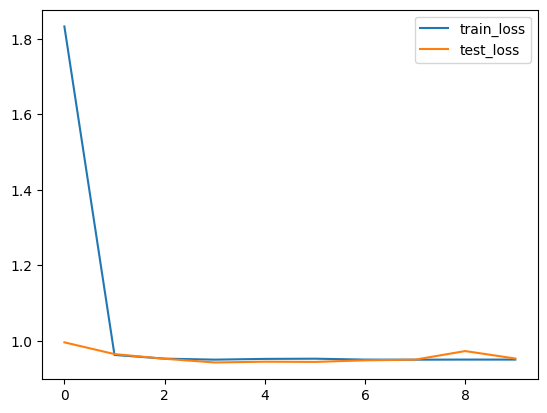

In [8]:
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='test_loss')
plt.legend()
plt.show()